# Notebook Data Preprocessing

In [1]:
import os
import yaml
import json
import torch
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [2]:
# Config
data_path = Path.cwd().parent / 'data' / 'Agricultural-crops'

## 1. Create data

In [3]:
# Create dataframe from dataset

image_paths = []
labels = []

for label in os.listdir(data_path):
    folder_path = data_path / label
    # print(folder_path)
    for path in folder_path.glob("*"): 
        # print(path)
        image_paths.append(path)
        labels.append(label)    

df = pd.DataFrame({
    "image_paths": image_paths,
    "labels": labels
})

In [4]:
# Split dataset
train_df, test_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    shuffle=True, 
    stratify=df["labels"]
)

train_df, val_df = train_test_split(
    train_df, 
    test_size=0.1,
    random_state=42,
    shuffle=True,
)

In [5]:
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 522, Val: 58, Test: 249


## 2. Define image transform

In [6]:
class RGBA2RGB:
    def __call__(self, img):
        if img.mode == "RGBA":
            img = img.convert("RGB")
        elif img.mode == "L":
            img = img.convert("RGB")
        return img

In [7]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    RGBA2RGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2, contrast= 0.2, saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]) 

val_transform = transforms.Compose([
    RGBA2RGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]) 

test_transform = transforms.Compose([
    RGBA2RGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]) 

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.labels = sorted(df.labels.unique())
        self.cls_2_idx = {}
        self.idx_2_cls = {}
        for i, crp in enumerate(self.labels):
            self.cls_2_idx[crp] = i
            self.idx_2_cls[i] = crp
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['image_paths']
        label = self.df.iloc[index]['labels']
        image = Image.open(image_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        label_idx = self.cls_2_idx[label]
        return image, label_idx        

# 3. Create Datasets and DataLoaders


In [9]:
# Create dataset
train_dataset = CustomDataset(df=train_df, transforms=train_transforms)
val_dataset = CustomDataset(df=val_df, transforms=val_transform)
test_dataset = CustomDataset(df=test_df, transforms=test_transform)

In [10]:
# Create dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# Visualize one batch

def show_batch(dataloader, dataset):
    images, labels_idx = next(iter(dataloader))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img * 0.229 + 0.485, 0, 1)  # unnormalize
        plt.imshow(img)
        plt.title(dataset.idx_2_cls[(labels_idx[i]).item()])
        plt.axis('off')
    plt.show()

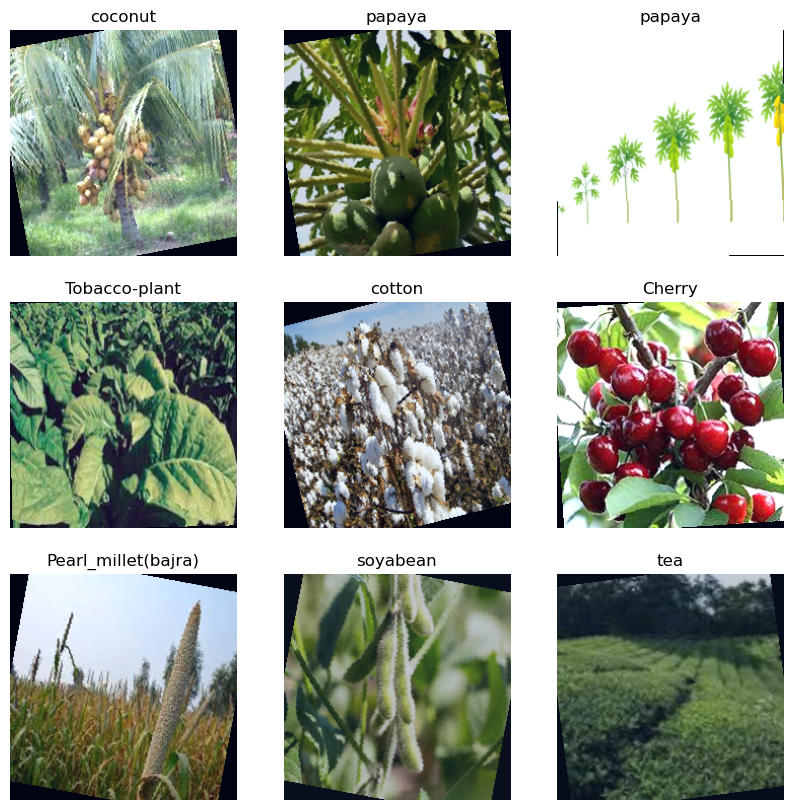

In [12]:
show_batch(train_dataloader, train_dataset)

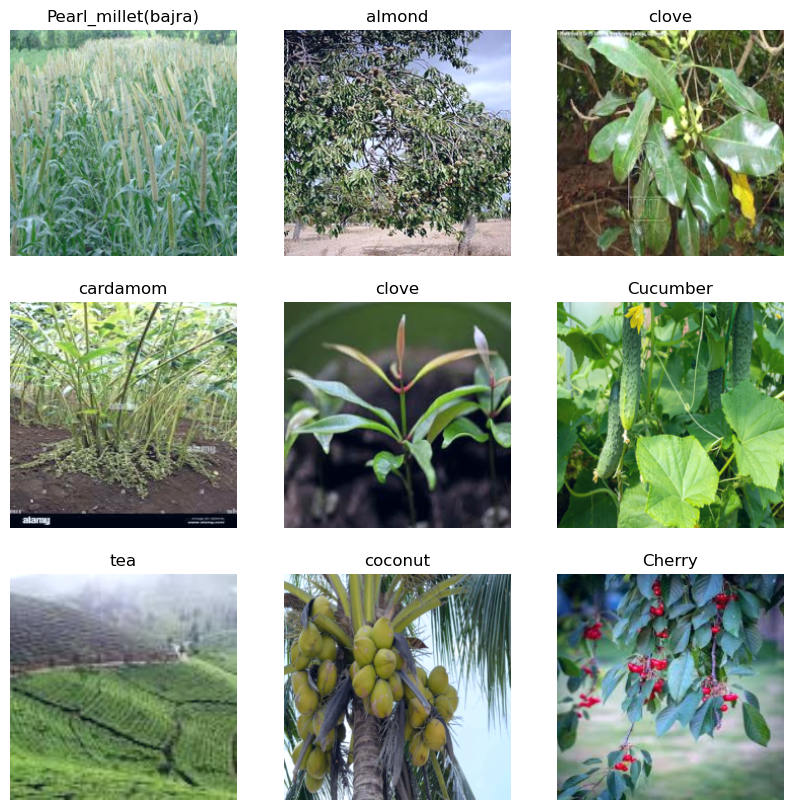

In [13]:

show_batch(test_dataloader, test_dataset)

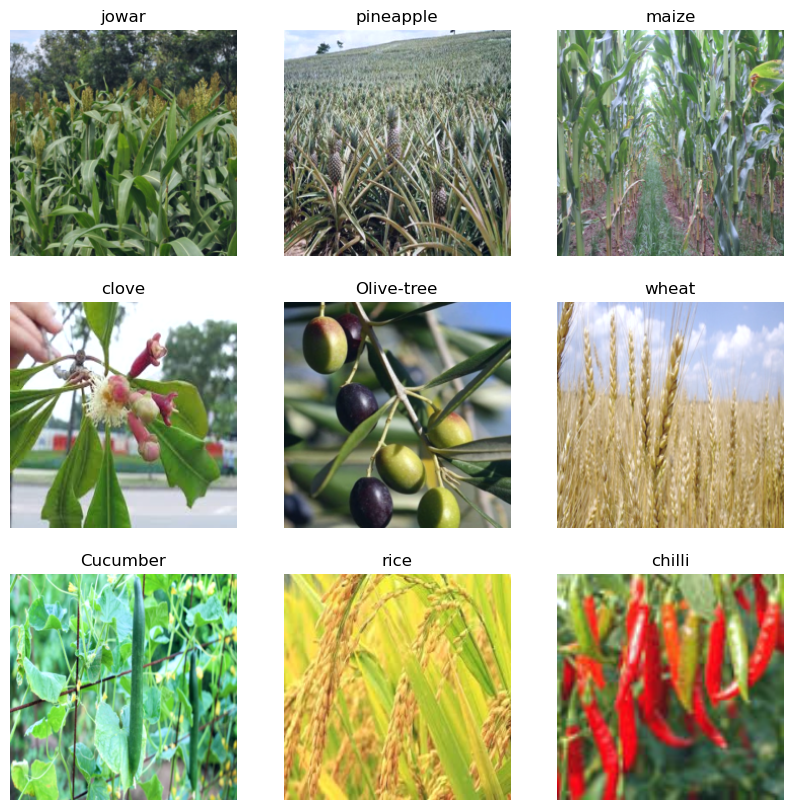

In [14]:
show_batch(val_dataloader, val_dataset)

# Create config file

In [30]:
config = {
    "IMG_SIZE": IMG_SIZE,
    "BATCH_SIZE": BATCH_SIZE,
    "NUM_CLASSES": len(train_dataset.cls_2_idx.keys()),
    "CLASSES": list(train_dataset.cls_2_idx.keys()),
    "NORMALIZE_MEAN": [0.485, 0.456, 0.406],
    "NORMALIZE_STD": [0.229, 0.224, 0.225],
}

In [31]:
config_path = Path.cwd().parent / 'config' / 'data_config.yaml'
config_path.parent.mkdir(exist_ok=True)
with open(config_path, "w") as f:
    yaml.dump(config, f)
print(f"Data preprocessing complete. Config saved to {config_path}")

Data preprocessing complete. Config saved to c:\Users\hongquan\Documents\GitHub\agri-crop-classification\agri-crop-classification-main\config\data_config.yaml


In [33]:
splits_path = Path.cwd().parent / "data_splits"
splits_path.mkdir(exist_ok=True)

train_df.to_csv(splits_path / "train_split.csv", index=False)
val_df.to_csv(splits_path / "val_split.csv", index=False)
test_df.to_csv(splits_path / "test_split.csv", index=False)